# Exercise 2 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2025/26
 * Lecture by: Constantin Pape
 * Organizers: Anwai Archit, Sushmita Nair
 * Tutors: Azhar Akhmetova, Benjamin Eckhardt, Carolin Teuber, Luca Freckmann, Marei Freitag, Oleg Bakumenko, Sarah Muth
 * Due date: **Tuesday, Nov 25, before 10:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling

*We are looking forward to seeing your solutions! Have fun!*

## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (.ipynb file). No other file is required.
    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 2` -> `Tutorial X` (where X is the tutorial you are assigned to).
- Make only one submission of the exercise per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand

Implementation:
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### How to work on the exercise?
You will need access to a machine with a GPU to properly work on the exercises. We recommend using [JupyterHPC](https://jupyter.hpc.gwdg.de/), which offers convenient access to a GPU. We have provided access to all the dependencies that we need preinstalled ([here](https://docs.google.com/document/d/1frgBvU9ZRcR7PkMqOuK5eTj5RphZBmjz_i6OgA1DVwE/edit?usp=sharing) are the initial steps and step-by-step guide to get started with working on JupyterHPC).

In addition, another recommended solution would be using [Kaggle](https://www.kaggle.com/), which also offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are the initial steps to work the Kaggle Notebooks). You can load this notebook on Kaggle via `File` -> `Import Notebook` -> `Browse Files` and `Import`.

### Imports

In [18]:
!pip install fastprogress

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
from pathlib import Path
import os
import sys
import time
import importlib

In [20]:
project_path = Path(os.environ.get("PROJECT")).resolve()

## 1. Setup

You can use the functions to grab the data, split the sets, create the dataloaders and plot results, etc. given to you at exercise sheet 1.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you use JupyterHPC (recommended), the file with functions from exercise 1 is already uploaded to `$PROJECT/utils/setup.py`.

Hint:
To load a custom script from path you can use `importlib` module together with this code:
```python
spec = importlib.util.spec_from_file_location("module_name", module_path)
s = importlib.util.module_from_spec(spec) # we call it s for setup
spec.loader.exec_module(s)
```
and validate it for example by getting the device: `s.get_device()`.

Alternatively you can copy the file to your workspace using terminal `cp $PROJECT/utils/setup.py $HOME/your/notebook/location/` and import as usuall:

`import setup as s`


#### For Kaggle users
If you work with Kaggle you have to mount the drive first and create a path to your python module or download the file from drive.
Create a file named `setup.py` and copy all the necessary functions to it, e.g. dataset preparation and training. 

Alternativelly you can download this file to your workspace from drive and import it on this notebook. 
File URL is https://drive.google.com/file/d/1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk/view?usp=share_link

Hint:
For download you can use the package `gdown`

```python
!conda install -y gdown
!gdown <file_id>
```

where, `file_id` is "1066jDUxp8fXwdcNGj8h0CWJA0KNLpvKk"

Then, setup.py should be added to your workspace and you can import it as usual module `import setup as s` 

In [21]:
# TODO: Import setup.py#
import torch
import numpy as np
import random
import os
from pathlib import Path
import importlib.util

#Seeding
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

#Load setup.py from Ex1
project_path = Path(os.environ.get("PROJECT")).resolve()
setup_path = project_path / "utils" / "setup.py"

print("Loading setup.py from:", setup_path)

spec = importlib.util.spec_from_file_location("setup", setup_path)
s = importlib.util.module_from_spec(spec)
spec.loader.exec_module(s)

#Test that is loaded correctly
device = s.get_device()
print("Device from setup.py:", device)

#Config
CONFIG = {
    "batch_size":512,
    "valid_frac": 0.1,
    "seed": SEED,
}
CONFIG


Loading setup.py from: /mnt/ceph-hdd/projects/scc_umin_pape_dlforcv2526/utils/setup.py
cuda available: True; cudnn available: True; num devices: 1
Using device NVIDIA A100-SXM4-80GB MIG 1g.10gb
Device from setup.py: cuda:0


{'batch_size': 512, 'valid_frac': 0.1, 'seed': 42}

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of `setup.py` to instantiate the train-, test- and validation CIFAR10 datasets along with their dataloaders.

In [22]:
# TODO: Define device
device = s.get_device()
device

cuda available: True; cudnn available: True; num devices: 1
Using device NVIDIA A100-SXM4-80GB MIG 1g.10gb


device(type='cuda', index=0)

In [23]:
from utils.setup import train, validate, run_training, plot

In [24]:
data_dir = Path(project_path, "data", "Ex1")
batch_size = 512

# TODO: Grab data, generate split and initialize data loaders

#Download datasets using.py helper
train_set, test_set = s.grab_data(str(data_dir), dataset="CIFAR10")
print("raw train_set size:", len(train_set), "test_set size:" , len(test_set))
#Split train,train+val
train_set, val_set = s.generate_train_val_data_split(train_set, split_seed=CONFIG["seed"],val_frac=CONFIG["valid_frac"])
print("After split -> train:", len(train_set), " val:", len(val_set))

#Create Dataloaders
train_loader, val_loader, test_loader = s.init_data_loaders(train_set, val_set, test_set, batch_size=batch_size)
print("Dataloaders created:")
print(" train_loader batch size:", batch_size, "->", type(train_loader))
print(" val_loader ->", type(val_loader))
print("test_loader ->", type(test_loader))

#Class Names (CIFAR default)
try:
    class_names = train_set.dataset.classes if hasttr(train_set, "dataset") and hasattr(train_set.dataset, "classes") else getattr(train_set, "classes", None)
except Exception:
    class_names = None
if class_names is None:
    class_names = [str(i) for i in range(10)]

print("class_names:", class_names)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
raw train_set size: 50000 test_set size: 10000
After split -> train: 45000  val: 5000
Dataloaders created:
 train_loader batch size: 512 -> <class 'torch.utils.data.dataloader.DataLoader'>
 val_loader -> <class 'torch.utils.data.dataloader.DataLoader'>
test_loader -> <class 'torch.utils.data.dataloader.DataLoader'>
class_names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [25]:
# TODO: Define loss function
import torch.nn as nn
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

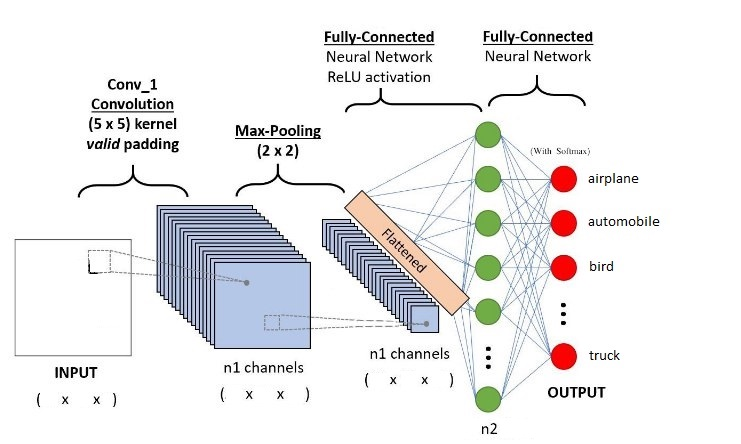

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What is the size of each input (i.e value of `in_features`) to the first fully connected linear layer?
- What is the number of parameters for conv_1?

**Your answers here**
- The input dimensions are 32x32x3
- The dimensions of the feature maps are 28x28x32. Output size M=(n-k)/s+1, here: M=(32-5)/1+1=28
- The dimensions after pooling are 14x14x32, since stride is usually equal to the size of the pooling region.
- The size of each input to the first fully connected linear layer is 6,272 and occurs from flattening the 14x14x32 channels.
- The number of parameters for conv_1 is 2,400, because we have 5x5x3=75 weights (parameters) for each filter, and we have 32 filters, so 75x32=2,400 in total. (We would have 2,432 if we were also including biases for each filter.)

In [10]:
# TODO: Define model
class CNN_1layer(nn.Module):
    def __init__(self):
        super(CNN_1layer, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size= 5, stride=1),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*14*14, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x= self.features(x)
        x= self.classifier(x)
        return(x)     

#### **TODO**

- Train the model for 10 epochs. Try lr=0.001 (can be changed to suit other design choices you make)
- Plot the results of accuracy and loss as you did in exercise sheet 1.

Finished training after 115 seconds.


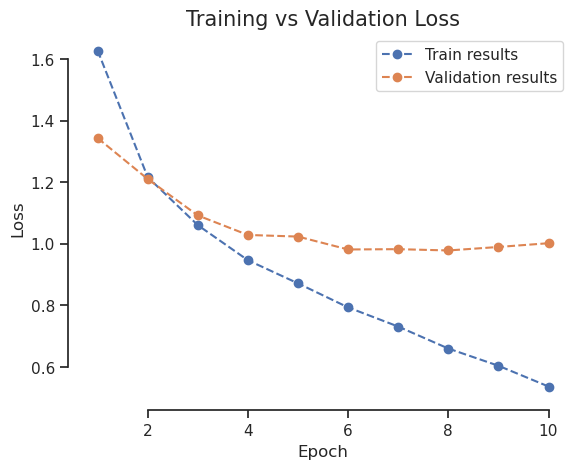

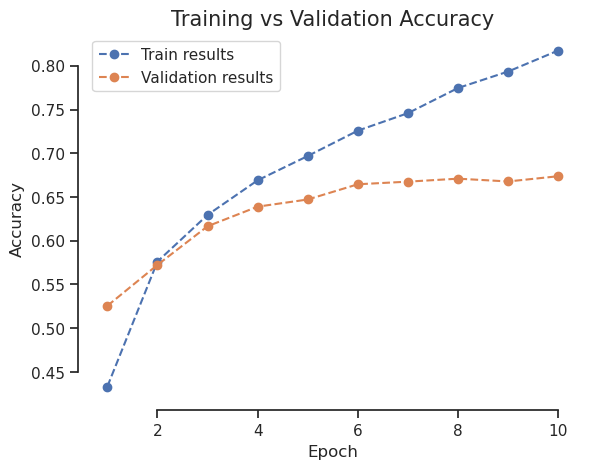

In [11]:
# TODO: Train and plot
model = CNN_1layer()
model = model.to(device)
lr= 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, _  = run_training(
    model=model,
    optimizer=optimizer,
    loss_function=loss_fn,
    device=device,
    num_epochs=10,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    early_stopper=None,     
    verbose=True
)

plot(
    title="Training vs Validation Loss",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses
)

plot(
    title="Training vs Validation Accuracy",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs
)

#### **TODO**
Compare results to the MLP models you trained in Exercise 1. What can you observe?

**Your answers here**
- Our validation accuracy is slightly better (0.65), compared to the MLP model's accuracy (0.45)
- CNN is runs faster than the fully connected MLP (110 seconds), compared to (1112 seconds). This is probably because CNNs are optimized for images, since they take advantage of the spatial locality. They reduce the input dimensionality through convolution and pooling, while the MLPs have to process very high dimensional vectors. Also a CNN can use fewer parameters than a fully connected MLP 
- In the CNN plots, we observe that even though the training loss decreases continuously, the validation loss plateaus ~3-4 epochs. This is a sign of overfitting, our model is fitting the training data too well, but it's not generalizing to new data. Similarly, in the MLP loss plot we can notice a very big gap between the training and the validation loss, which indicates the same, that our model is overfitting the data and is not generalizing well.


**For your reference, below is the loss and accuracy plots of an MLP model trained in Exercise sheet 1:**

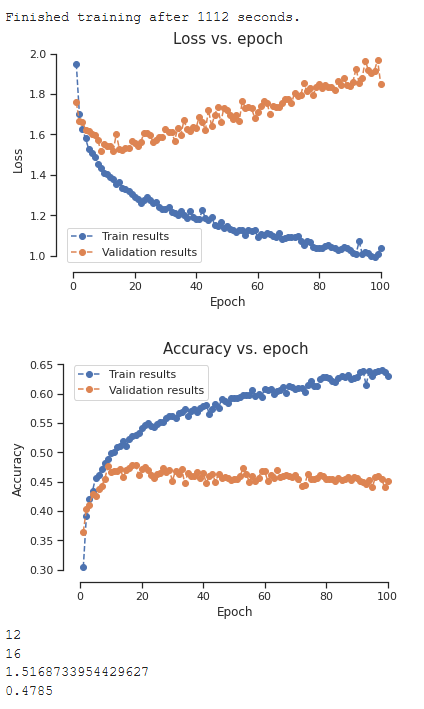

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 679 seconds.


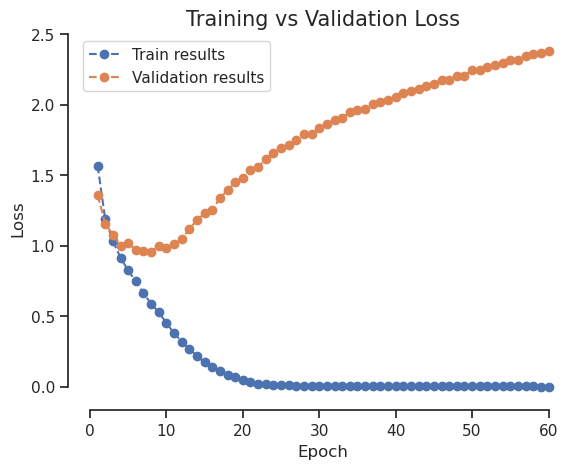

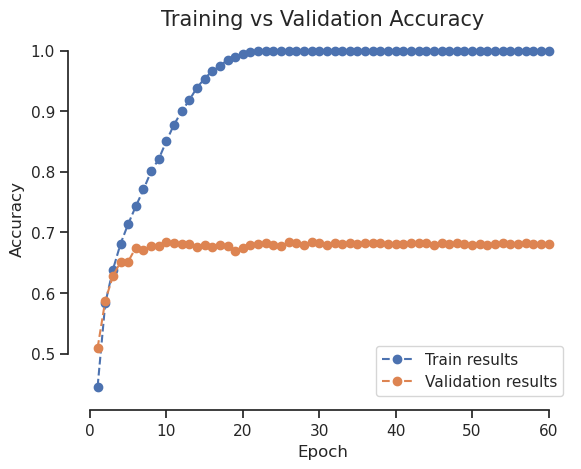

In [12]:
# TODO: Train and plot
model = CNN_1layer()
model = model.to(device)
lr= 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, _  = run_training(
    model=model,
    optimizer=optimizer,
    loss_function=loss_fn,
    device=device,
    num_epochs=60,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    early_stopper=None,     
    verbose=True
)

plot(
    title="Training vs Validation Loss",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses
)

plot(
    title="Training vs Validation Accuracy",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs
)

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**
- It is again overfitting.
- Our model is too shallow for the hierarchical and spatial complexity of our images. With one hidden layer only our CNN can learn to recognize simple features, like edges or colour blobs, but it cannot combine these features to form and recognize higher-level features like objects.
- We can add more layers to our CNN, so that it can learn more complex features.

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture using the following information:



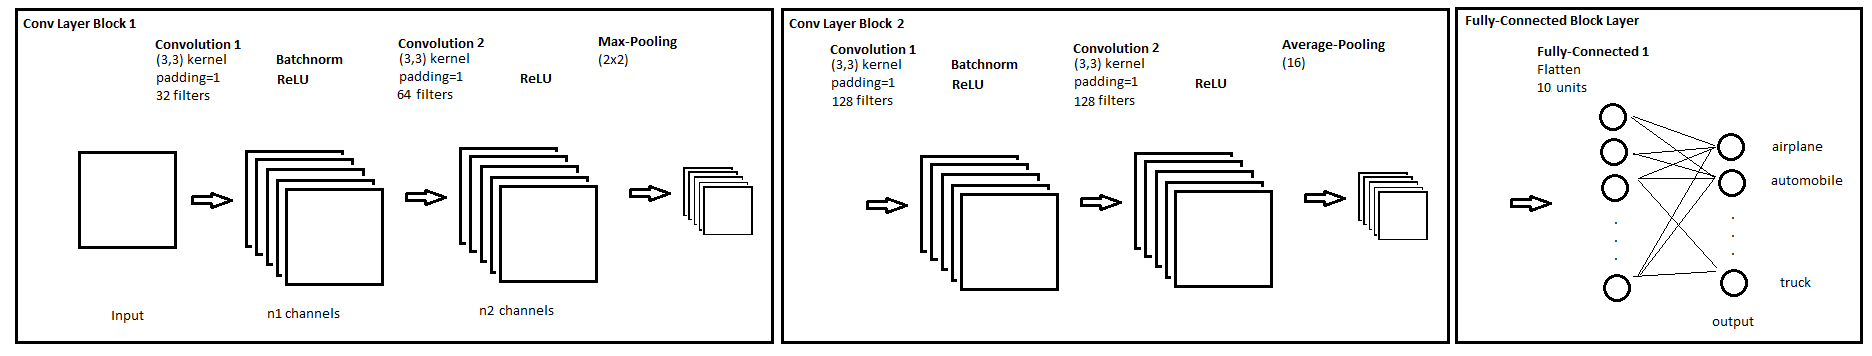

*   Convolutional layer 1: with 32 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 2: with 64 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Max pooling with kernel size of 2*2
*   Convolutional layer 3: with 128 filters, kernel size of 3*3 and padding 1.
*   Batchnorm and ReLU layers
*   Convolutional layer 4: with 128 filters, kernel size of 3*3 and padding 1.
*   ReLU Activation layer
*   Average pooling with kernel size 16*16
*   Fully connected layer

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**
- Padding is used to preserve the spatial dimensions of the input image after convolution operations on a features map. There aare two types of padding, "valid" padding, also called "no padding" that doesn't add any extra pixels to the input image and "same" padding, which adds zeros around the input image to keep the output size equal to the input size, after convolution.
- Padding = 1 means adding a layer of pixels (zeros) around the border of the input data. In our case for instance, the input data are 32X32 which means that after the padding the size will be 34X34.
- Because of the padding the size of the input image is 34x34 and since the kernel is 3X3, the size of the feature map after the 1. conv layer is 34x34 (34-3)/1+1= 32. We devide by 1 because the stride is equal to 1. So we observe that the output size matches the input size, as we were expecting since we used the "same" padding technique. So output is 32x32x32, as we use 32 filters. (Or Output size M=N+2p-k+1, here M=32+2*1-3+1=32)
- After the 2. conv layer the dimensions of the feature maps are also 32x32, since we use padding= 1 again, and as we have 64 filters, the output dimensions are 64x32x32.
- The receptive field size=1+sum(k_l -1), here we have l=2, k_1=3 and k_2=3, so the RF size=1+(3-1)+(3-1)=5. So the receptive field is 5x5.
- We know already that after 2. conv the output is 64x32x32. Then with the max pooling technique it becomes 64x16x16, after 3. conv 128x16x16 because we use padding=1 and again 128x16x16 after the 4. conv because of the "same" padding and lastly with the average polling with kernel size=16 it becomes 128x1x1. So then after flattening the input size is 128x1x1=128.
- The number of parameters in conv1 are (3x3x3)x32= 864 for all the filters with kernel size 3x3. Then we also 2 learnable parameters for the BatchNorm for the 32 input channels, so 64 parameters. So in total we have 864+64= 928 parameters and if we also include the bias terms for each filer, we have 32 parameters more, ending up with 928+32= 960 parameters.

In [26]:
# TODO: Define model 2
class CNN_morelayers(nn.Module):
    def __init__(self, num_classes= 10):
        super(CNN_morelayers, self).__init__()

        self.features = nn.Sequential(
            # Conv Layer 1
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size= 3, padding= 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Conv Layer 2
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= 3, padding= 1),
            nn.ReLU(),

            # Max Pooling
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            
            # Conv Layer 3
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 3, padding= 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Conv Layer 4
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size= 3, padding= 1),
            nn.ReLU(),     

            # Average Pooling
            nn.AvgPool2d(kernel_size = 16)
            
        )

        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x= self.features(x)
        x = torch.flatten(x, 1)
        x= self.classifier(x)
        return(x) 

#### **TODO** 

- train the new net (30 epochs, try lr=0.1 or change as necessary), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

Finished training after 472 seconds.


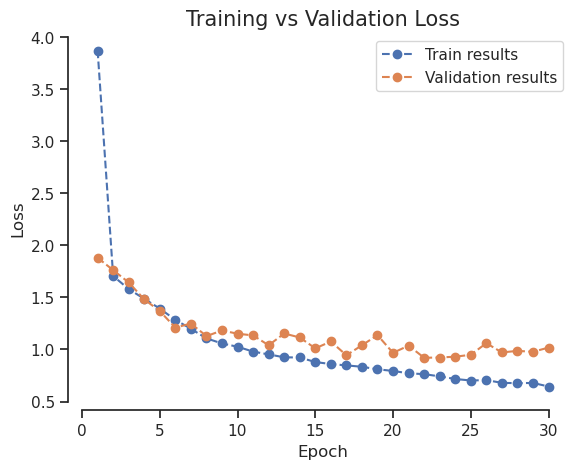

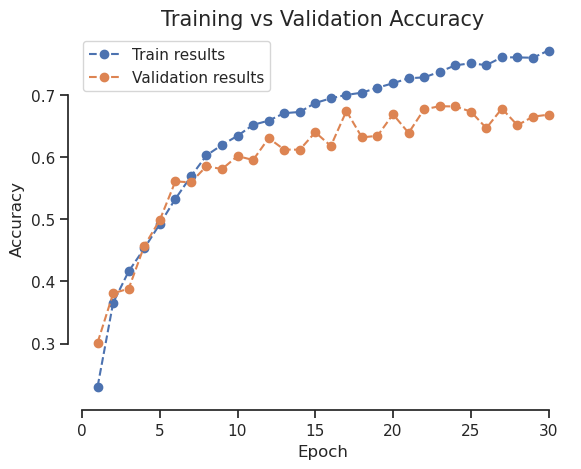

In [28]:
# TODO: Train and plot
model = CNN_morelayers()
model = model.to(device)
lr= 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, _  = run_training(
    model=model,
    optimizer=optimizer,
    loss_function=loss_fn,
    device=device,
    num_epochs=30,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    early_stopper=None,     
    verbose=True
)

plot(
    title="Training vs Validation Loss",
    label="Loss",
    train_results=train_losses,
    val_results=val_losses
)

plot(
    title="Training vs Validation Accuracy",
    label="Accuracy",
    train_results=train_accs,
    val_results=val_accs
)

We notice that the CNN with more layers, performs slightly better than the shallow one, with the validation accuracy reaching 67% and also without overfitting. We observe this because we have more layers and our CNN can capture and learn more complex features, thus also generalizing better to new data.

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

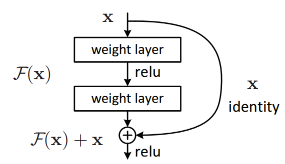

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- Train the model and plot results
- Train another model by disable residual connections and compare performance

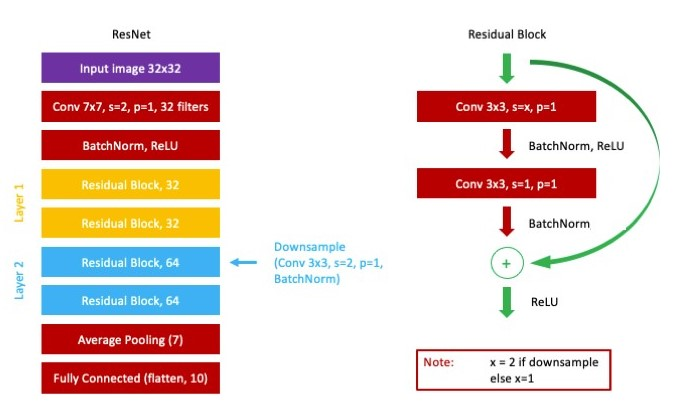

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [ ]:
# TODO: Write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet

In [ ]:
# TODO: Write a class ResNet(nn.Module) where you define the model

In [ ]:
# TODO: Train ResNet using the architecture laid out in the comments and figures above. Plot loss and accuracy for training and validation set.

In [ ]:
# TODO: Train another model by disabling all residual connections. Plot loss and accuracy curves for training and validation set.

#### **Questions**
- Does using residual connections result in better performance in this exercise? If yes, why? If not, when would the benefit of using ResNet be most visible?
- In deeper networks, how would you expect residual blocks to influence training time? why?
- Compare the performance and training time of your ResNet with the CNNs you trained in the previous section.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*`torch.optim.lr_scheduler`* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use `StepLR` (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [ ]:
# TODO: Change run_training (you can copy the code from setup.py here and create a new method here
# or just change/create a new method it in the python file)

In [ ]:
# TODO: Train and plot with step size 1, gamma 0.1

In [ ]:
# TODO: Train and plot with step size 1, gamma 0.9

#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

In [ ]:
# TODO: Train and plot with step size 15, gamma 0.1, 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

## 7. LR-Scheduling _(Optional)_

#### TODO _(Optional)_
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

In [ ]:
# TODO (Optional): Train and plot with different schedulers

**Your answers here**